In [1]:
import datetime as dt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import glob
from tidegauge_functions import read_GPS_SONEL

%matplotlib inline

In [2]:
datum = 'dAB48_XXXXXXXXX_JPL14.neu'
dir_in = 'data/GPS'

In [3]:
pattern = os.path.join(dir_in, datum)
print(pattern)

data/GPS\dAB48_XXXXXXXXX_JPL14.neu


In [4]:
filenames = sorted(glob.glob(pattern))  # , key=alphanum_key)

In [15]:
def test_calc_OLS(df, var, start, end):
    df = df[start:end]
    x, y = np.arange(len(df[var].dropna())), df[var].dropna()
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    res = model.fit()
    return res

def test_plot_OLS(df, res, res2, site, var, trend_array, trend_array2, point1, point2):
    df1 = df[(df.index <= point1)]
    df2 = df[(df.index >= point2)]
    fig, ax = plt.subplots(1, 1, figsize=(12,6));
    ax.plot(df[var].dropna().index, df[var].dropna().values, 
            label='trend', marker='.', linestyle='', color = 'darkgrey')
    ax.plot(df1[var].dropna().index, [res1.params.x1*i + res1.params.const for i in np.arange(len(df1[var].dropna()))],
           marker = '', linestyle = '-', color = 'blue')
    ax.plot(df2[var].dropna().index, [res2.params.x1*i + res2.params.const for i in np.arange(len(df2[var].dropna()))],
           marker = '', linestyle = '-', color = 'red')
    # ax[1].plot(df['Vertical'].dropna().index, res.resid.values);
    # ax[1].plot(df['Vertical'].dropna().index, np.abs(res.resid.values));
    # ax[1].hlines(0, 0, len(res.resid), color='k');
    plt.axvline(dt.datetime(2013, 1, 5), color= 'red', linestyle='--')
    ax.set_title(f" Pre 2013 Earthquake Trend = {trend_array * 1:.2f} mm/yr, Post 2013 Earthquake Trend= {trend_array2 * 1:.2f} mm/yr", fontsize=18);
    # ax[1].set_title("Residuals");
    plt.suptitle("Port Alexander, Alaska, USA", fontsize=20)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Vertical Land Motion (mm)', fontsize=18)
    plt.rc('xtick',labelsize=16)
    plt.rc('ytick',labelsize=16)
    plt.savefig(f'figs/GPS_OLS_split_exclude_nonlinear_{site}.png')
    
    

In [13]:
def convert_trend_toyearly(df, res):
    
    period = df.index.year.value_counts().max()
    yearlytrend = res.params.x1 * period
    
    return yearlytrend



data/GPS\dAB48_XXXXXXXXX_JPL14.neu
f: 0
Trend 1 = 0.81 mm/yr
                            OLS Regression Results                            
Dep. Variable:               Vertical   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     150.7
Date:                Thu, 13 Aug 2020   Prob (F-statistic):           1.14e-33
Time:                        08:28:59   Log-Likelihood:                -8132.3
No. Observations:                2483   AIC:                         1.627e+04
Df Residuals:                    2481   BIC:                         1.628e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

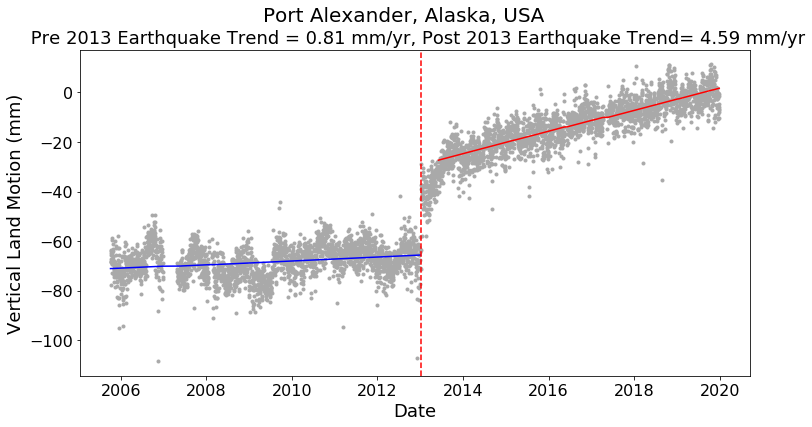

In [16]:
SONEL_trend_array = np.full(np.shape(filenames)[0], np.nan)
SONEL_trend_array2 = np.full(np.shape(filenames)[0], np.nan)
site_name_array = []


for f, filepath in enumerate(filenames):
    print(f'\n\n{filepath}')
    print(f'f: {f}')
    ## ToDo - extract and keep other important thing about each site from the file...Lat/Lon, name, etc.
    
    # Read in data
    df = read_GPS_SONEL(filepath)
    
    # Get trend using linear regression
    res1 = test_calc_OLS(df, 'Vertical', '2005-10-6', '2013-1-1')
    SONEL_trend_array[f] = convert_trend_toyearly(df, res1)
    
    res2 = test_calc_OLS(df, 'Vertical', '2013-6-5','2020-1-1')
    SONEL_trend_array2[f] = convert_trend_toyearly(df, res2)
    
    # Save site name
    site_name_array.append(filepath[-24:-20])
    
    print(f"Trend 1 = {SONEL_trend_array[f] * 1:.2f} mm/yr")
    print(res1.summary())
    print(f"Trend 2 = {SONEL_trend_array2[f] * 1:.2f} mm/yr")
    print(res2.summary())
   
    # Make Plot
    test_plot_OLS(df, res1, res2, filepath[-18:-14], 'Vertical', SONEL_trend_array[f], SONEL_trend_array2[f], '2013-1-1','2013-6-5')